In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(203)
import numpy as np
np.random.seed(345)
from rich import print

In [2]:
from pathlib import Path

# Running a negotiation

NegMAS has several built-in negotiation `Mechanisms`, negotiation agents (`Negotiators`), and `UtilityFunctions`. You can use these to run negotiations as follows.

Imagine a buyer and a seller negotiating over the price of a single object. First, we make an issue "price" with 50 discrete values. Note here, it is possible to create multiple issues, but we will not include that here. If you are interested, see the [NegMAS documentation](https://negmas.readthedocs.io/en/latest/tutorials/01.running_simple_negotiation.html) for a tutorial.

In [3]:
from negmas import (
    make_issue,
    SAOMechanism,
   TimeBasedConcedingNegotiator,
)
from anl.anl2024.negotiators import Boulware, Conceder, RVFitter
from negmas.preferences import LinearAdditiveUtilityFunction as UFun
from negmas.preferences.value_fun import IdentityFun, AffineFun
import matplotlib.pyplot as plt


# create negotiation agenda (issues)
issues = [
    make_issue(name="price", values=50),
]

# create the mechanism
session = SAOMechanism(issues=issues, n_steps=20)

The negotiation protocol in NegMAS is handled by a `Mechanism` object. Here we instantiate a`SAOMechanism` which implements the [Stacked Alternating Offers Protocol](https://ii.tudelft.nl/~catholijn/publications/sites/default/files/Aydogan2017_Chapter_AlternatingOffersProtocolsForM.pdf). In this protocol, negotiators exchange offers until an offer is accepted by all negotiators (in this case 2), a negotiators leaves the table ending the negotiation or a time-out condition is met. In the example above, we use a limit on the number of rounds of `20` (a step of a mechanism is an executed round).

Next, we define the utilities of the seller and the buyer. The utility function of the seller is defined by the ```
IdentityFun```  which means that the higher the price, the higher the utility function. The buyer's utility function is reversed. The last two lines make sure that utility is scaled between 0 and 1.

In [4]:
seller_utility = UFun(
    values=[IdentityFun()],
    outcome_space=session.outcome_space,
)

buyer_utility = UFun(
    values=[AffineFun(slope=-1)],
    outcome_space=session.outcome_space,
)

seller_utility = seller_utility.normalize()
buyer_utility = buyer_utility.normalize()


Then we add two agents with a boulware strategy. The negotiation ends with status overview. For example, you can see if the negotiation timed-out, what agreement was found, and how long the negotiation took. Moreover, we output the full negotiation history. For a more visual representation, we can plot the session. This shows the bidding curve, but also the proximity to e.g. the Nash point.

SAOState(
    running=False,
    waiting=False,
    started=True,
    step=18,
    time=0.002451625005051028,
    relative_time=0.9047619047619048,
    broken=False,
    timedout=False,
    agreement=(23,),
    results=None,
    n_negotiators=2,
    has_error=False,
    error_details='',
    erred_negotiator='',
    erred_agent='',
    threads={},
    last_thread='',
    current_offer=(23,),
    current_proposer='seller-80d7aeb4-4638-443b-8c7d-4fe87aedea1a',
    current_proposer_agent=None,
    n_acceptances=2,
    new_offers=[('seller-80d7aeb4-4638-443b-8c7d-4fe87aedea1a', (23,))],
    new_offerer_agents=[None],
    last_negotiator='seller',
    current_data=None,
    new_data=[]
)

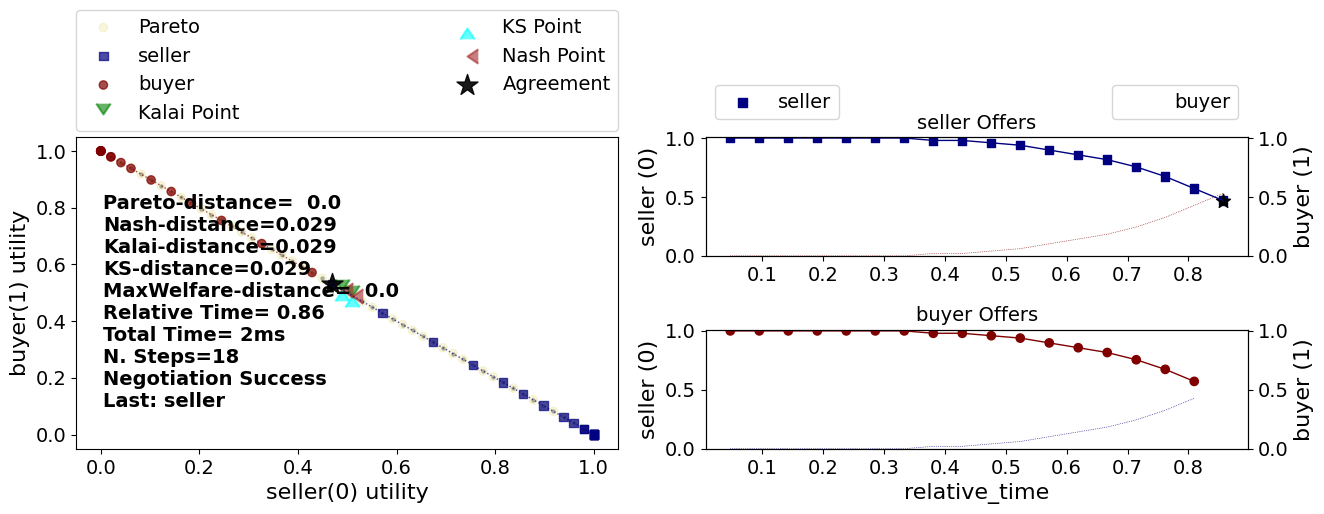

In [5]:
# create and add agent A and B
session.add(Boulware(name="seller"), ufun=seller_utility)
session.add(Boulware(name="buyer"), ufun=buyer_utility)

# run the negotiation and show the results
print(session.run())
session.plot(ylimits=(0.0, 1.01), show_reserved=False, mark_max_welfare_points=False)
plt.show()



## Running a Multi-deal negotiation

ANL 2025's challenge is to develop agents capable of negotiating sequentially a set of interrelated deals (Multi-deal negotiation). You can create and run a multi-deal negotiation using special tools provided by the anl2025 package.

### A random multideal-session

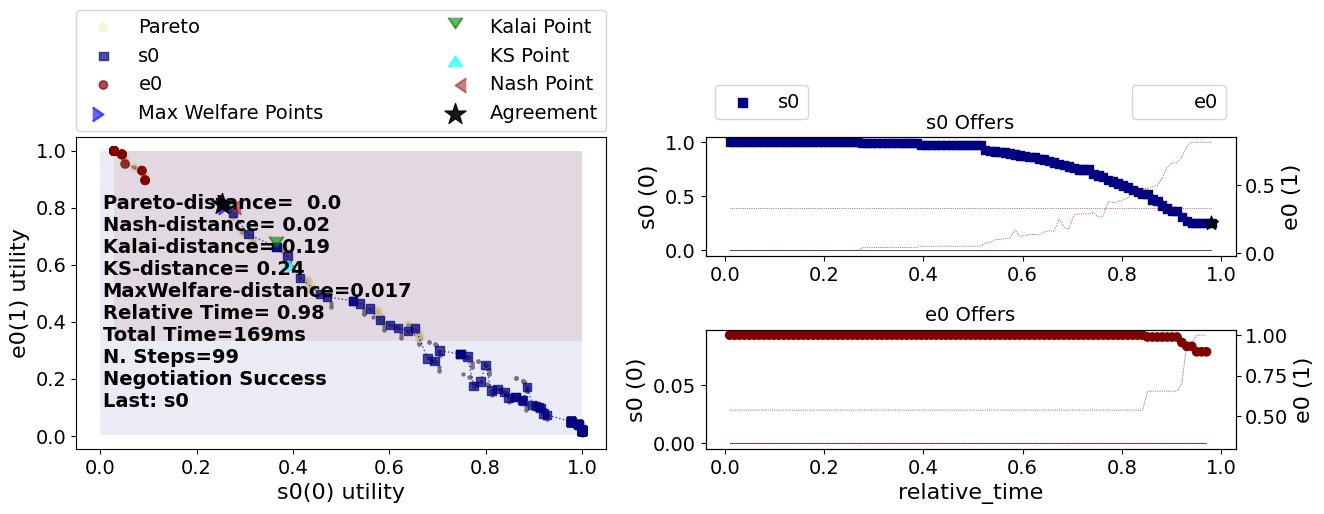

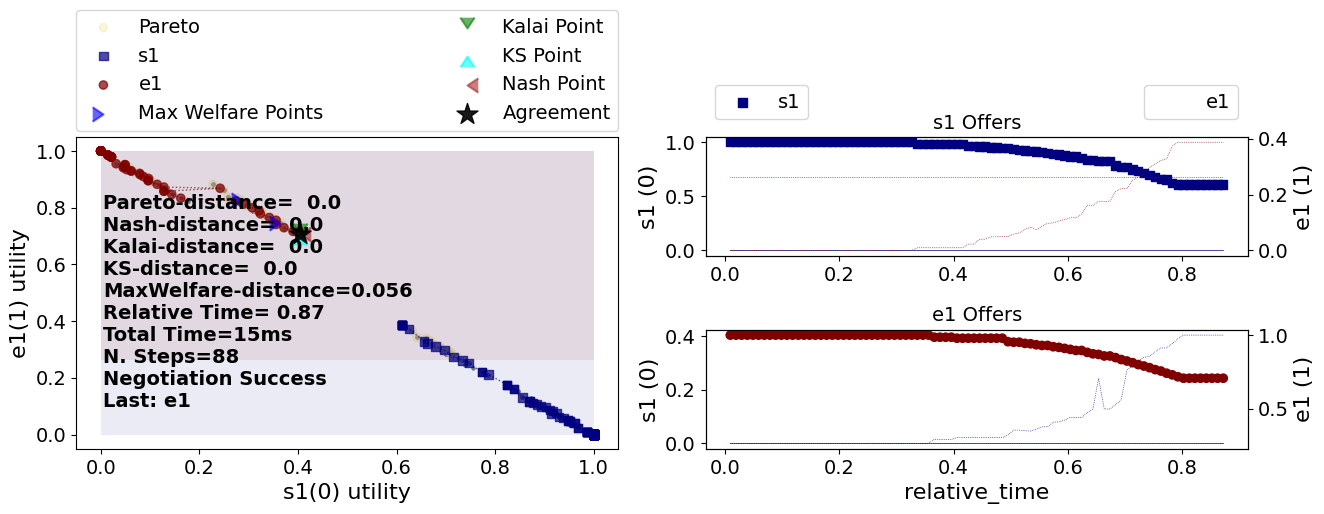

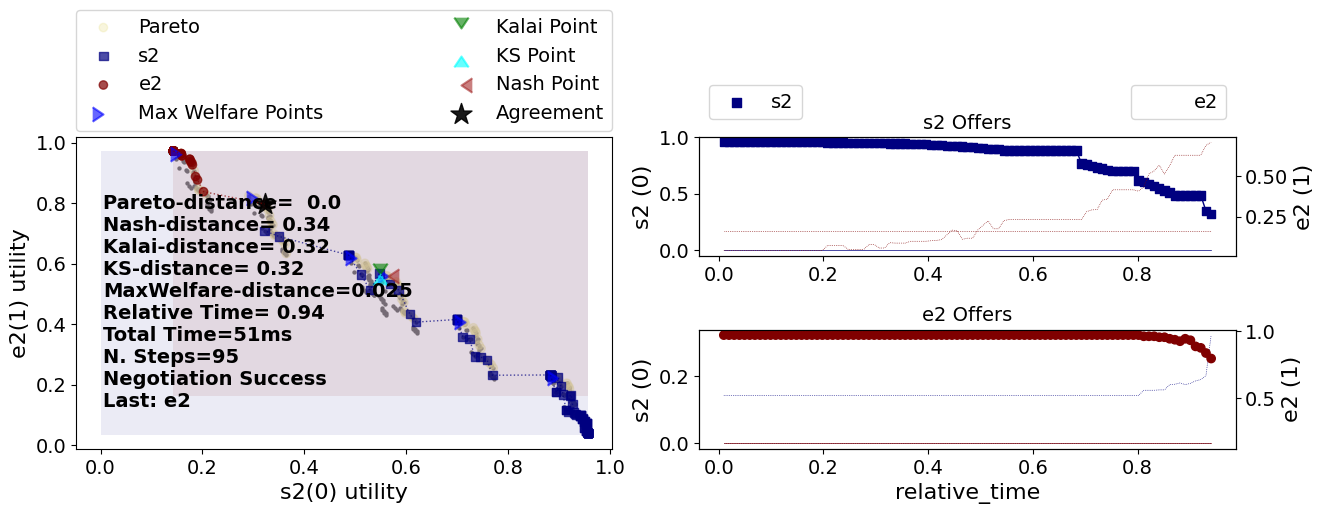

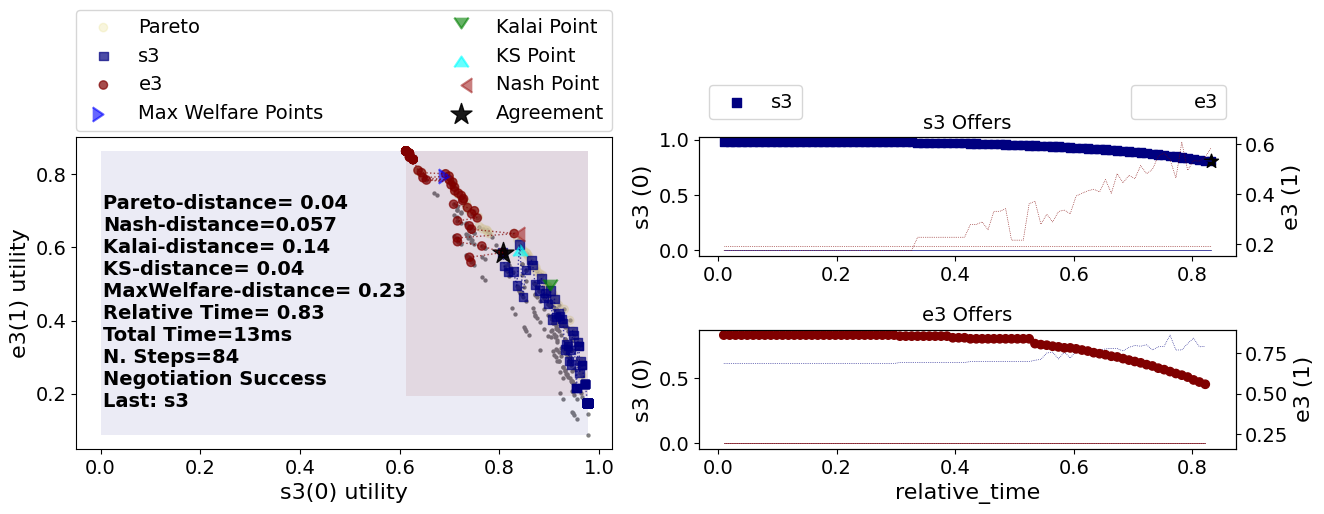

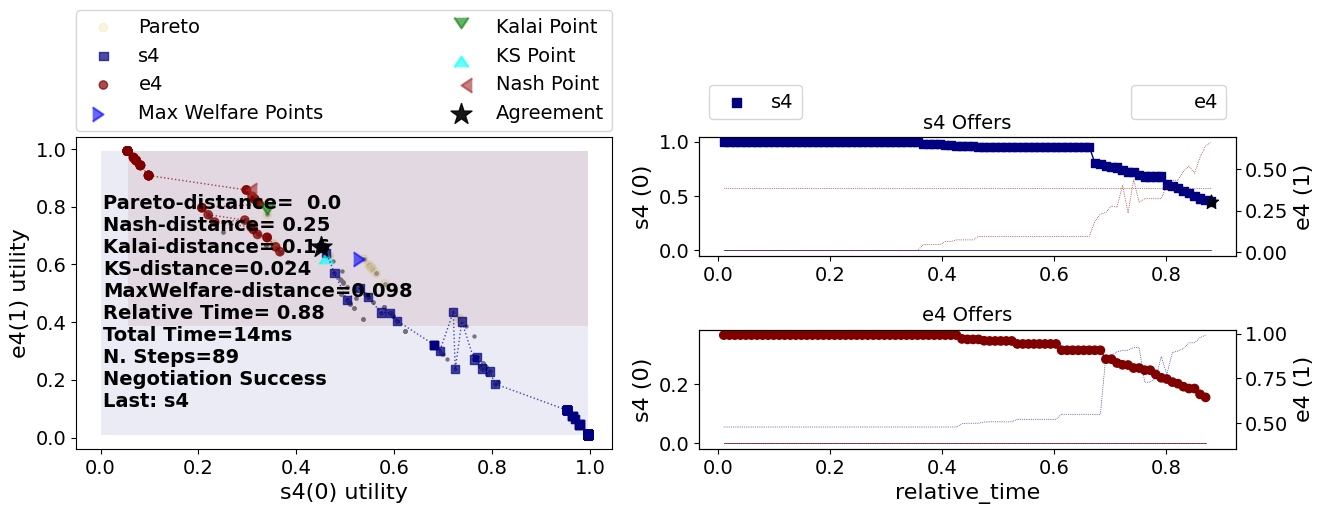

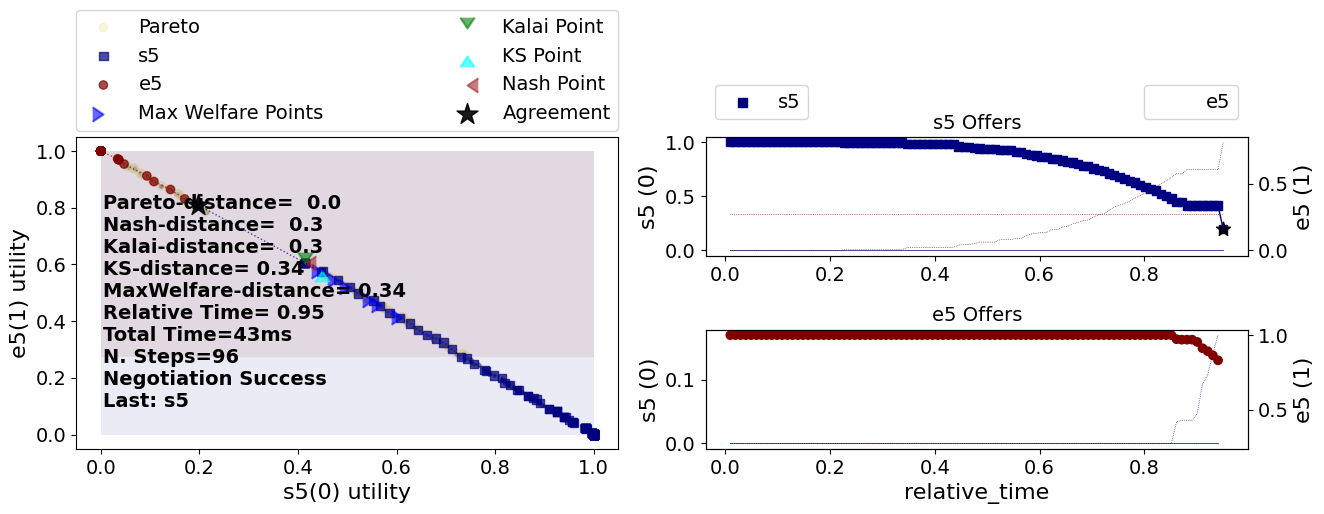

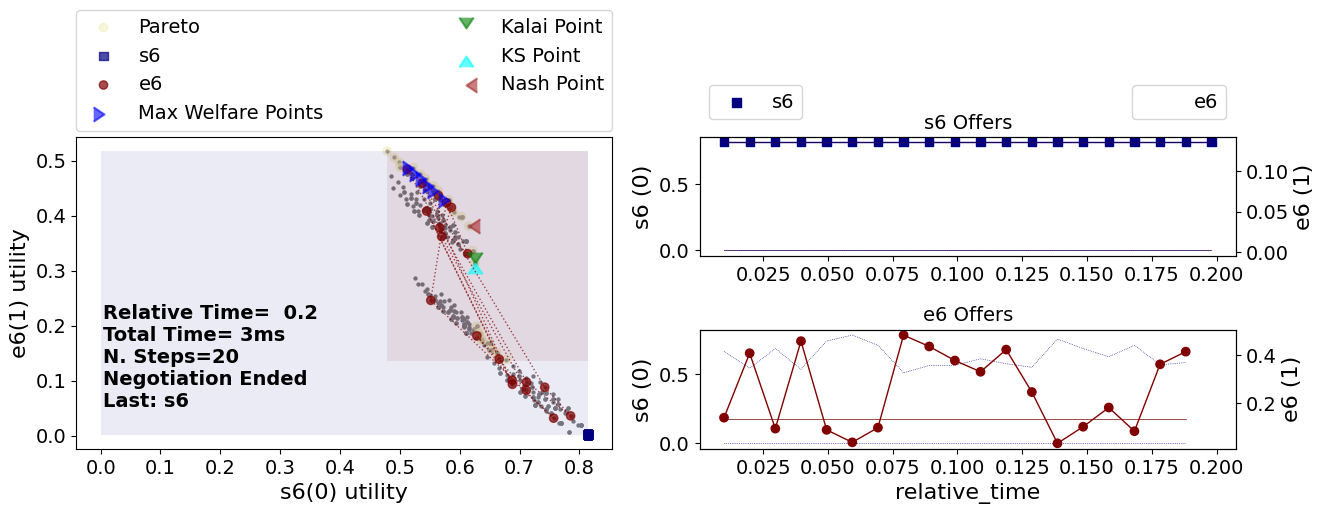

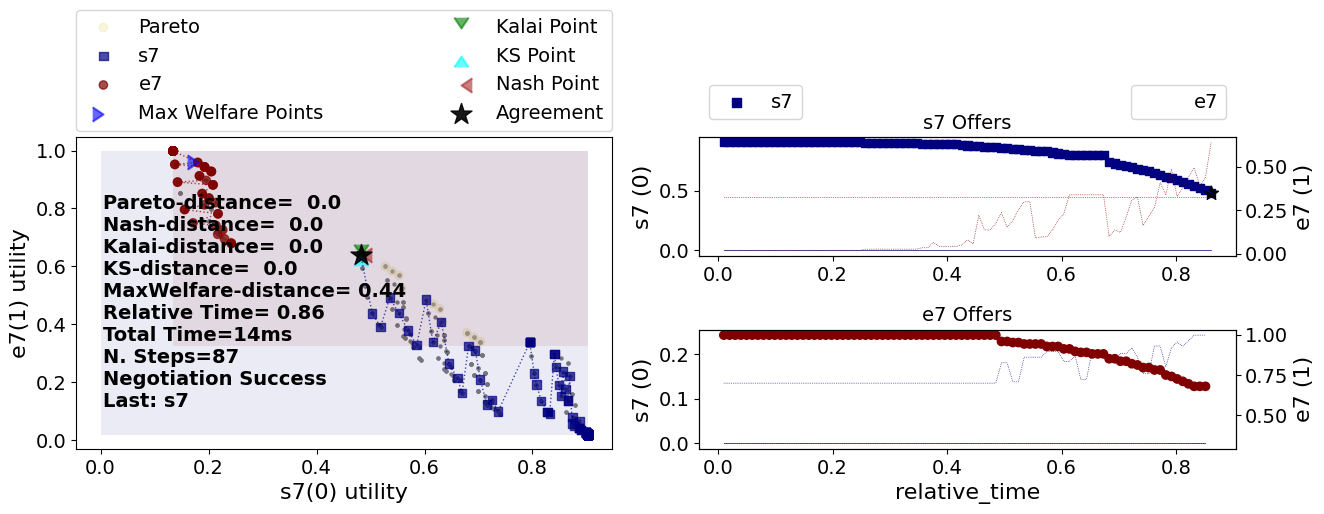

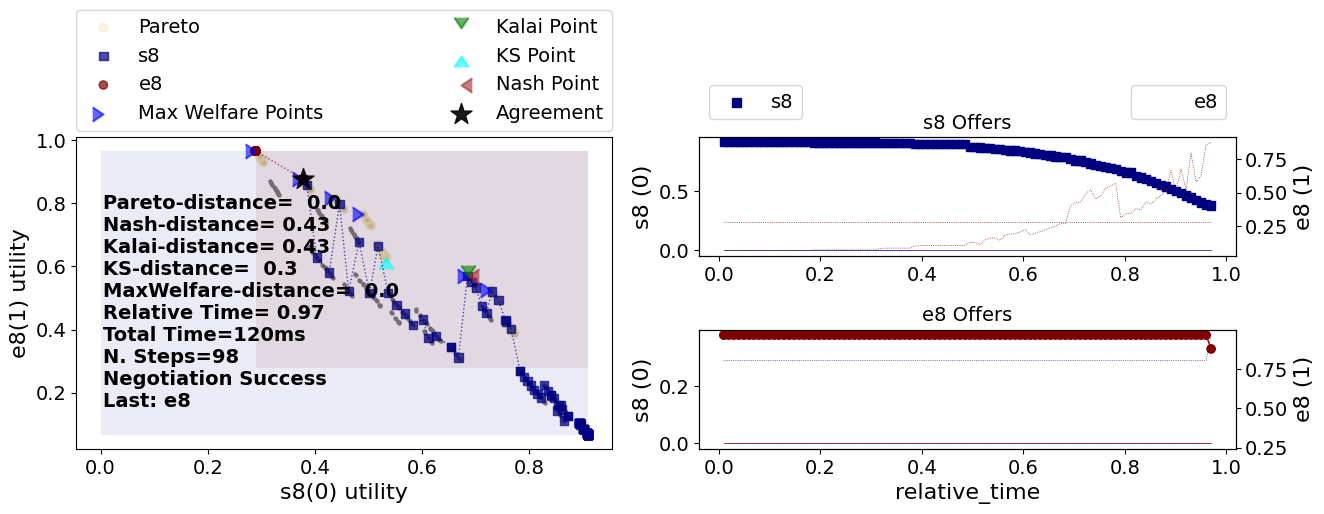

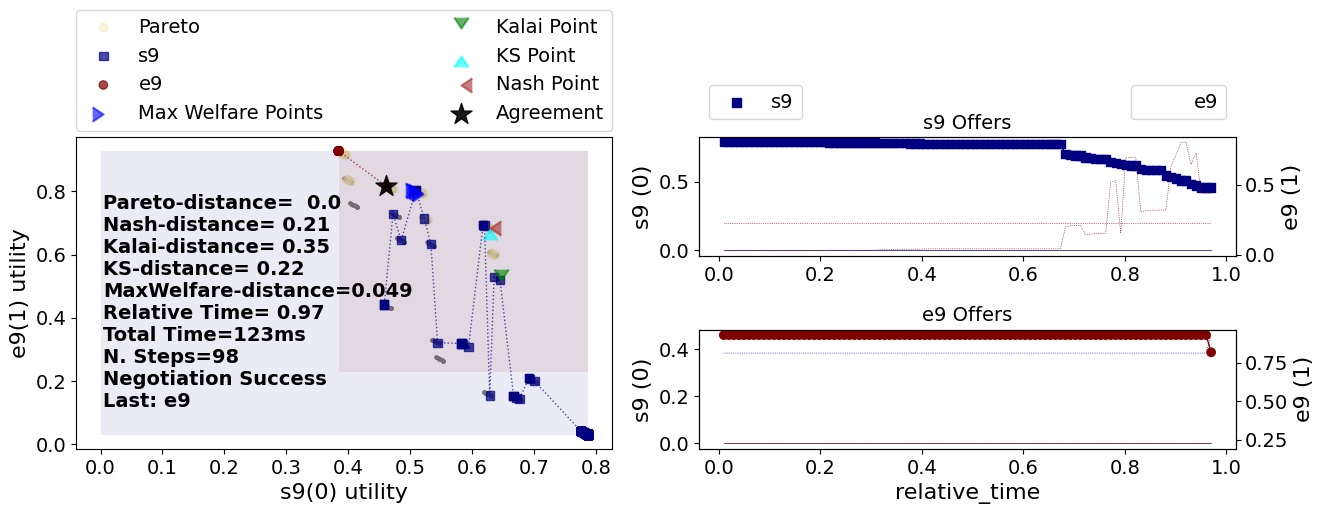

In [6]:
from anl2025.runner import run_generated_session

results = run_generated_session(dry=False, share_ufuns=True)

In [7]:
(results.center_utility, results.edge_utilities)

(0.8064004798167423,
 [0.8131581325119084,
  0.7069642861846106,
  0.7970860699307104,
  0.5856207500458452,
  0.6613510005000873,
  0.8099863916172095,
  0.13546488362061687,
  0.6393243356945096,
  0.8772281974265113,
  0.8167210114052037])

### A dinners' scheduling session


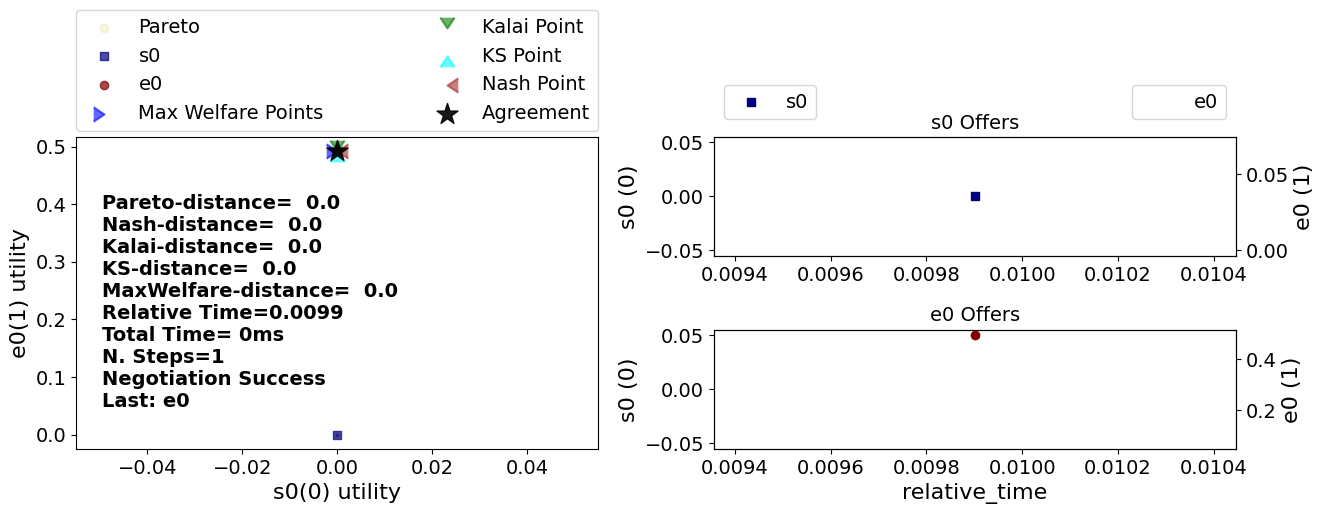

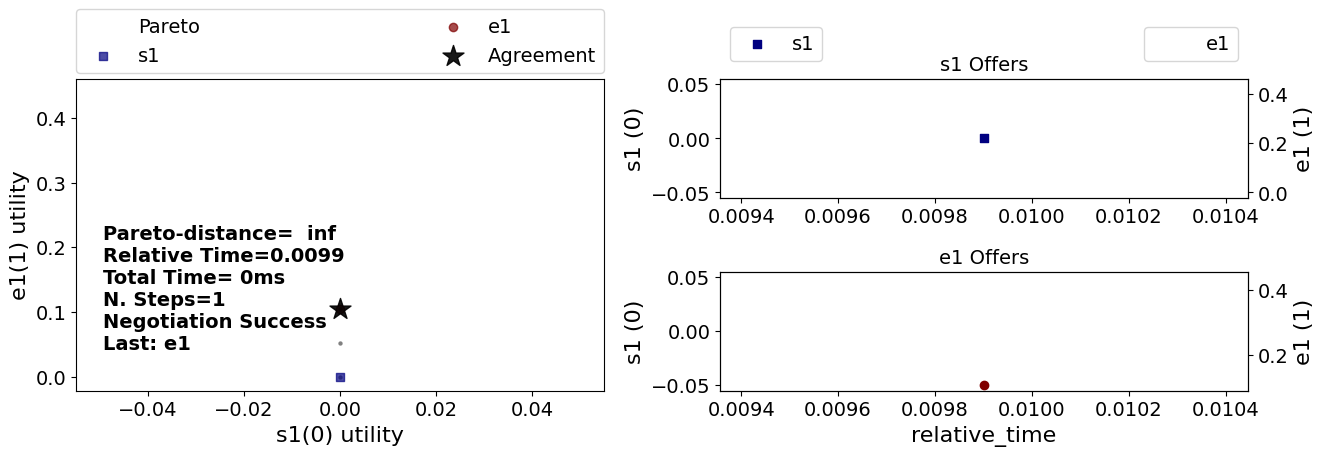

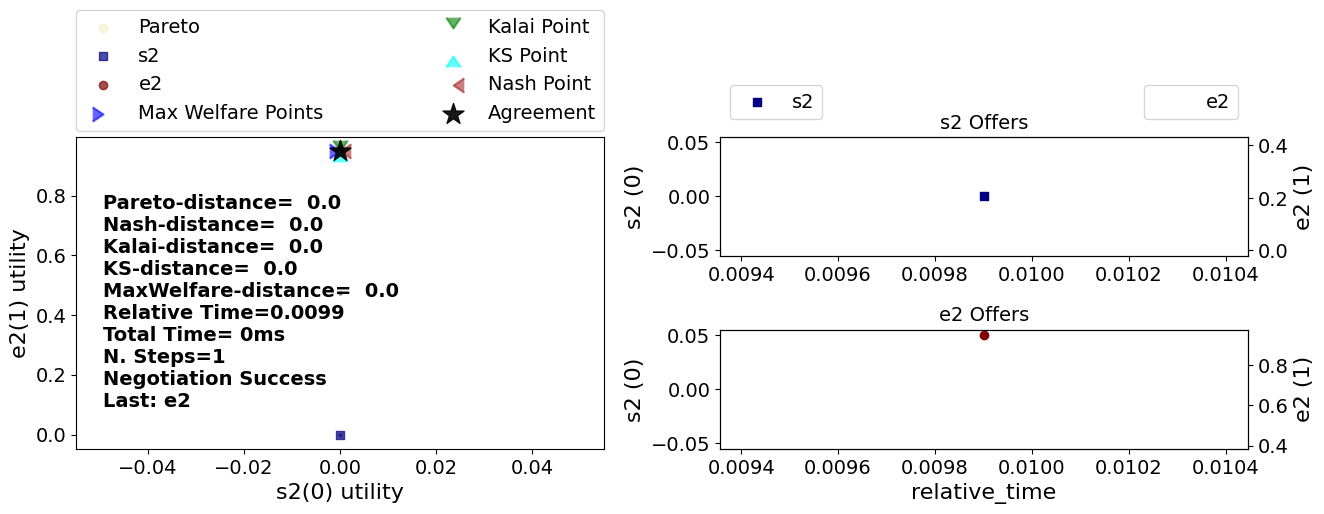

In [10]:
from anl2025 import make_dinners_scenario, run_session

results = run_session(make_dinners_scenario())